# 2. Pruning

This notebook demonstrates how to prune a model using the `torh.torch.nn.utils.prune` and `torch-pruning` library. Pruning is a technique to reduce the size of a neural network by removing weights that are deemed unnecessary, which can lead to faster inference times and reduced memory usage.

There is 2 types of pruning:
- **Unstructured pruning**: Removes individual weights using an importance metric (e.g., low-magnitude weights are pruned). This can lead to sparse models, which reduce drastically the number of parameters but must rely on specialized hardware and/or libraries to take advantage of the sparsity during inference.
- **Structured pruning**: Removes entire channels or layers, using a metric measuring an entire channel or layer importance (e.g., low-magnitude channels are pruned). This leads to a more regular model that can be used on standard hardware without requiring specialized libraries.

Metrics used for pruning are typically based on the magnitude of weights, gradients, or other statistics that indicate the importance of a weight or a channel.

The process is defined as such:
* A Torch model is loaded.
* A pruning strategy is defined, which specifies how to prune the model (e.g., unstructured or structured pruning, and the importance metric to use).
* The model is pruned using the defined strategy.
* The model is exported PyTorch format for further optimization or deployment.

2 pruning methods will be used in this notebook, both for 2 models (image and audio classification):
* L1-magntiude unstructured pruning using `torch.torch.nn.utils.prune`.
* L1-magnitude structured pruning using `torch-pruning`.

# Setup

In [1]:
from typing import Any

import torch

from matplotlib import pyplot as plt

from nnopt.model.eval import eval_model
from nnopt.model.prune import prune_finetune, count_model_parameters
from nnopt.model.const import DEVICE, DTYPE

from nnopt.recipes.mobilenetv2_cifar10 import get_mobilenetv2_cifar10_model, get_cifar10_datasets, save_mobilenetv2_cifar10_model

In [2]:
# MobilenetV2 CIFAR-10 model
mobilenetv2_cifar10_baseline, mobilenetv2_cifar10_baseline_metadata = get_mobilenetv2_cifar10_model(version="mobilenetv2_cifar10/baseline",)

# CIFAR-10 datasets
cifar10_train_dataset, cifar10_val_dataset, cifar10_test_dataset = get_cifar10_datasets()

2025-06-10 21:57:27,521 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loading MobileNetV2 model for CIFAR-10 from version: mobilenetv2_cifar10/baseline at /home/pbeuran/repos/nnopt/models
2025-06-10 21:57:27,754 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loaded metadata: {'metrics_values': {'val_metrics': {'accuracy': 0.7796, 'avg_loss': 0.6432003515243531, 'samples_per_second': 4038.3580272218437, 'avg_time_per_batch': 0.015672493328692545, 'avg_time_per_sample': 0.00024762539459334223, 'n_params': 2236682, 'n_nonzero_params': 2236682}, 'test_metrics': {'accuracy': 0.9016, 'avg_loss': 0.28529461288452146, 'samples_per_second': 7993.7841294417485, 'avg_time_per_batch': 0.00796797442669642, 'avg_time_per_sample': 0.0001250971984991338, 'n_params': 2236682, 'n_nonzero_params': 2236682}}}
2025-06-10 21:57:27,755 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loading existing training and validation datasets...
2025-06-10 21:57:29,323 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loading exi

In [3]:
# Evaluate the adapted model on the validation and test set
mobilenetv2_cifar10_baseline_val_metrics = eval_model(
    model=mobilenetv2_cifar10_baseline,
    test_dataset=cifar10_val_dataset,
    device=DEVICE,
    use_amp=False,
    dtype=torch.float32,
)
mobilenetv2_cifar10_baseline_test_metrics = eval_model(
    model=mobilenetv2_cifar10_baseline,
    test_dataset=cifar10_test_dataset,
    device=DEVICE,
    use_amp=False,
    dtype=torch.float32,
)

mobilenetv2_cifar10_val_accuracy_baseline = mobilenetv2_cifar10_baseline_val_metrics["accuracy"]
mobilenetv2_cifar10_test_accuracy_baseline = mobilenetv2_cifar10_baseline_test_metrics["accuracy"]
print(f"Validation accuracy of MobileNetV2 on CIFAR-10 (baseline): {mobilenetv2_cifar10_val_accuracy_baseline:.2f}")
print(f"Test accuracy of MobileNetV2 on CIFAR-10 (baseline): {mobilenetv2_cifar10_test_accuracy_baseline:.2f}")

2025-06-10 21:57:29,470 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.float32, batch size: 32
2025-06-10 21:57:29,486 - nnopt.model.eval - INFO - Starting warmup for 5 batches...
[Warmup]: 100%|██████████| 5/5 [00:00<00:00,  6.82it/s]
2025-06-10 21:57:30,280 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 157/157 [00:04<00:00, 37.55it/s, acc=0.7802, cpu=3.3%, gpu_mem=6.5/24.0GB (27.3%), gpu_util=21.0%, loss=0.4882, ram=10.0/30.9GB (36.8%), samples/s=482.2]  
2025-06-10 21:57:34,505 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.float32, batch size: 32
2025-06-10 21:57:34,508 - nnopt.model.eval - INFO - Starting warmup for 5 batches...


Evaluation Complete: Avg Loss: 0.6448, Accuracy: 0.7802
Throughput: 6160.66 samples/sec | Avg Batch Time: 5.17 ms | Avg Sample Time: 0.16 ms
System Stats: CPU Usage: 9.20% | RAM Usage: 9.8/30.9GB (36.4%) | GPU 0 Util: 21.00% | GPU 0 Mem: 6.5/24.0GB (27.3%)


[Warmup]: 100%|██████████| 5/5 [00:00<00:00, 25.77it/s]
2025-06-10 21:57:34,772 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 313/313 [00:04<00:00, 74.46it/s, acc=0.9005, cpu=3.3%, gpu_mem=6.5/24.0GB (27.2%), gpu_util=40.0%, loss=0.1314, ram=9.9/30.9GB (36.7%), samples/s=989.3]   


Evaluation Complete: Avg Loss: 0.2876, Accuracy: 0.9005
Throughput: 6034.38 samples/sec | Avg Batch Time: 5.29 ms | Avg Sample Time: 0.17 ms
System Stats: CPU Usage: 12.50% | RAM Usage: 9.8/30.9GB (36.2%) | GPU 0 Util: 35.00% | GPU 0 Mem: 6.5/24.0GB (27.2%)
Validation accuracy of MobileNetV2 on CIFAR-10 (baseline): 0.78
Test accuracy of MobileNetV2 on CIFAR-10 (baseline): 0.90


# L1 unstructured pruning

In [4]:
# Prune using L1 unstructured pruning, finetune, and evaluate for 0.5, 0.7, and 0.9 sparsity levels
unstruct_pruned_amount_model_version_map: dict[float, str] = {}
unstruct_pruned_amount_metrics_map: dict[float, Any] = {}
for sparsity in [0.5, 0.7, 0.9]:
    print("***" * 20)
    # Prune and finetune the model
    mobilenetv2_cifar10_pruned = prune_finetune(
    model=get_mobilenetv2_cifar10_model(version="mobilenetv2_cifar10/baseline")[0],
    train_dataset=cifar10_train_dataset,
    val_dataset=cifar10_val_dataset,
    pruning_method="l1_unstructured_pruning",
    pruning_amount=sparsity,
    batch_size=64,  # Adjust batch size as needed
    num_epochs=3,
    device=DEVICE,
    use_amp=True,
    dtype=DTYPE
)
    # Save the model and its metadata
    unstruct_pruned_amount_model_version_map[sparsity] = f"mobilenetv2_cifar10/l1_unstructured_pruning_{sparsity}"
    unstruct_pruned_amount_metrics_map[sparsity] = {
        "val_metrics": eval_model(
            model=mobilenetv2_cifar10_pruned,
            test_dataset=cifar10_val_dataset,
            batch_size=64,  # Adjust batch size as needed
            device=DEVICE,
            use_amp=False,
            dtype=torch.float32
        ),
        "test_metrics": eval_model(
            model=mobilenetv2_cifar10_pruned,
            test_dataset=cifar10_test_dataset,
            batch_size=64,  # Adjust batch size as needed
            device=DEVICE,
            use_amp=False,
            dtype=torch.float32
        ),
    }
    print(("***" * 20) + "\n")
    save_mobilenetv2_cifar10_model(
        model=mobilenetv2_cifar10_pruned,
        version=f"mobilenetv2_cifar10/l1_unstructured_pruning_{sparsity}",
        unstruct_sparse_config={
            "pruning_amount": sparsity
        },
        metrics_values=unstruct_pruned_amount_metrics_map[sparsity]
    )

2025-06-10 21:57:39,004 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loading MobileNetV2 model for CIFAR-10 from version: mobilenetv2_cifar10/baseline at /home/pbeuran/repos/nnopt/models
2025-06-10 21:57:39,096 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loaded metadata: {'metrics_values': {'val_metrics': {'accuracy': 0.7796, 'avg_loss': 0.6432003515243531, 'samples_per_second': 4038.3580272218437, 'avg_time_per_batch': 0.015672493328692545, 'avg_time_per_sample': 0.00024762539459334223, 'n_params': 2236682, 'n_nonzero_params': 2236682}, 'test_metrics': {'accuracy': 0.9016, 'avg_loss': 0.28529461288452146, 'samples_per_second': 7993.7841294417485, 'avg_time_per_batch': 0.00796797442669642, 'avg_time_per_sample': 0.0001250971984991338, 'n_params': 2236682, 'n_nonzero_params': 2236682}}}
2025-06-10 21:57:39,097 - nnopt.model.prune - INFO - Starting pruning with method: l1_unstructured_pruning, amount: 0.50
2025-06-10 21:57:39,097 - nnopt.model.prune - INFO - Applying L1 unstructured pru

************************************************************


2025-06-10 21:57:39,211 - nnopt.model.prune - INFO - Applied L1 unstructured pruning to 53 layers.
2025-06-10 21:57:39,211 - nnopt.model.prune - INFO - Evaluating the pruned model on the validation dataset...
2025-06-10 21:57:39,212 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.bfloat16, batch size: 64
2025-06-10 21:57:39,230 - nnopt.model.eval - INFO - Starting warmup for 5 batches...
[Warmup]: 100%|██████████| 5/5 [00:01<00:00,  3.72it/s]
2025-06-10 21:57:40,648 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 79/79 [00:04<00:00, 18.21it/s, acc=0.0952, cpu=3.6%, gpu_mem=6.7/24.0GB (27.9%), gpu_util=35.0%, loss=2.6348, ram=10.3/30.9GB (39.8%), samples/s=345.3]  
2025-06-10 21:57:45,005 - nnopt.model.prune - INFO - Validation accuracy for pruned method l1_unstructured_pruning with pruning amount 0.50: 0.0952
2025-06-10 21:57:45,006 - nnopt.model.prune - INFO - Starting finetuning of the pruned model...


Evaluation Complete: Avg Loss: 2.3846, Accuracy: 0.0952
Throughput: 4461.21 samples/sec | Avg Batch Time: 14.19 ms | Avg Sample Time: 0.22 ms
System Stats: CPU Usage: 11.20% | RAM Usage: 10.0/30.9GB (38.9%) | GPU 0 Util: 35.00% | GPU 0 Mem: 6.7/24.0GB (27.9%)


Epoch 1/3 [Validation]: 100%|██████████| 79/79 [00:04<00:00, 18.37it/s, acc=0.7230, cpu=5.7%, gpu_mem=9.1/24.0GB (37.8%), gpu_util=29.0%, loss=1.4595, ram=10.4/30.9GB (39.9%), samples/s=984.9]  


Epoch 1/3, Train Loss: 0.8860, Train Acc: 0.6895, Train Throughput: 1926.37 samples/s | Val Loss: 0.7804, Val Acc: 0.7230, Val Throughput: 5922.41 samples/s | CPU Usage: 12.20% | RAM Usage: 10.2/30.9GB (39.3%) | GPU 0 Util: 29.00% | GPU 0 Mem: 9.1/24.0GB (37.8%)


Epoch 2/3 [Validation]: 100%|██████████| 79/79 [00:04<00:00, 18.33it/s, acc=0.7494, cpu=2.9%, gpu_mem=9.1/24.0GB (37.8%), gpu_util=29.0%, loss=0.7373, ram=10.4/30.9GB (40.0%), samples/s=991.7]  


Epoch 2/3, Train Loss: 0.7539, Train Acc: 0.7381, Train Throughput: 1907.87 samples/s | Val Loss: 0.7339, Val Acc: 0.7494, Val Throughput: 5870.42 samples/s | CPU Usage: 10.30% | RAM Usage: 10.2/30.9GB (39.3%) | GPU 0 Util: 29.00% | GPU 0 Mem: 9.1/24.0GB (37.8%)


Epoch 3/3 [Validation]: 100%|██████████| 79/79 [00:04<00:00, 17.92it/s, acc=0.7696, cpu=2.9%, gpu_mem=9.1/24.0GB (37.8%), gpu_util=31.0%, loss=1.3562, ram=10.4/30.9GB (40.0%), samples/s=961.9]  
2025-06-10 21:59:47,015 - nnopt.model.prune - INFO - Evaluating the pruned and finetuned model on the validation dataset...
2025-06-10 21:59:47,016 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.bfloat16, batch size: 64
2025-06-10 21:59:47,019 - nnopt.model.eval - INFO - Starting warmup for 5 batches...


Epoch 3/3, Train Loss: 0.6951, Train Acc: 0.7581, Train Throughput: 1924.27 samples/s | Val Loss: 0.6754, Val Acc: 0.7696, Val Throughput: 5730.82 samples/s | CPU Usage: 11.80% | RAM Usage: 10.2/30.9GB (39.4%) | GPU 0 Util: 31.00% | GPU 0 Mem: 9.1/24.0GB (37.8%)


[Warmup]: 100%|██████████| 5/5 [00:00<00:00,  7.17it/s]
2025-06-10 21:59:47,800 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 79/79 [00:04<00:00, 18.48it/s, acc=0.7768, cpu=5.7%, gpu_mem=9.1/24.0GB (37.8%), gpu_util=34.0%, loss=1.0164, ram=10.4/30.9GB (40.2%), samples/s=995.3]  
2025-06-10 21:59:52,098 - nnopt.model.prune - INFO - Validation accuracy for pruned and finetuned model: 0.7768
2025-06-10 21:59:52,099 - nnopt.model.prune - INFO - Making pruning permanent by removing reparameterization...
2025-06-10 21:59:52,102 - nnopt.model.prune - INFO - Made pruning permanent for 53 layers.
2025-06-10 21:59:52,102 - nnopt.model.prune - INFO - Removed pruning reparameterization from the pruned finetuned model.
2025-06-10 21:59:52,102 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.float32, batch size: 64
2025-06-10 21:59:52,105 - nnopt.model.eval - INFO - Starting warmup for 5 batches...


Evaluation Complete: Avg Loss: 0.6505, Accuracy: 0.7768
Throughput: 3863.80 samples/sec | Avg Batch Time: 16.38 ms | Avg Sample Time: 0.26 ms
System Stats: CPU Usage: 9.90% | RAM Usage: 10.2/30.9GB (39.3%) | GPU 0 Util: 34.00% | GPU 0 Mem: 9.1/24.0GB (37.8%)


[Warmup]: 100%|██████████| 5/5 [00:00<00:00,  7.39it/s]
2025-06-10 21:59:52,870 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 79/79 [00:04<00:00, 18.51it/s, acc=0.7638, cpu=4.2%, gpu_mem=9.7/24.0GB (40.3%), gpu_util=34.0%, loss=0.8375, ram=10.4/30.9GB (40.2%), samples/s=1776.9] 
2025-06-10 21:59:57,157 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.float32, batch size: 64
2025-06-10 21:59:57,161 - nnopt.model.eval - INFO - Starting warmup for 5 batches...


Evaluation Complete: Avg Loss: 0.6801, Accuracy: 0.7638
Throughput: 3838.80 samples/sec | Avg Batch Time: 16.49 ms | Avg Sample Time: 0.26 ms
System Stats: CPU Usage: 10.50% | RAM Usage: 10.2/30.9GB (39.4%) | GPU 0 Util: 34.00% | GPU 0 Mem: 9.7/24.0GB (40.3%)


[Warmup]: 100%|██████████| 5/5 [00:00<00:00, 13.35it/s]
2025-06-10 21:59:57,619 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 157/157 [00:03<00:00, 41.65it/s, acc=0.8988, cpu=4.3%, gpu_mem=9.7/24.0GB (40.2%), gpu_util=51.0%, loss=0.1239, ram=10.4/30.9GB (40.1%), samples/s=3922.4] 
2025-06-10 22:00:01,451 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Metadata saved to /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/l1_unstructured_pruning_0.5/metadata.json
2025-06-10 22:00:01,452 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Model saved to /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/l1_unstructured_pruning_0.5/model.pt
2025-06-10 22:00:01,452 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loading MobileNetV2 model for CIFAR-10 from version: mobilenetv2_cifar10/baseline at /home/pbeuran/repos/nnopt/models
2025-06-10 22:00:01,540 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loaded metadata: {'metrics_values': {'val_metrics': {'accuracy': 0.7796, 'av

Evaluation Complete: Avg Loss: 0.2895, Accuracy: 0.8988
Throughput: 6026.49 samples/sec | Avg Batch Time: 10.57 ms | Avg Sample Time: 0.17 ms
System Stats: CPU Usage: 10.10% | RAM Usage: 10.2/30.9GB (39.4%) | GPU 0 Util: 51.00% | GPU 0 Mem: 9.7/24.0GB (40.2%)
************************************************************

************************************************************


2025-06-10 22:00:01,680 - nnopt.model.prune - INFO - Applied L1 unstructured pruning to 53 layers.
2025-06-10 22:00:01,681 - nnopt.model.prune - INFO - Evaluating the pruned model on the validation dataset...
2025-06-10 22:00:01,681 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.bfloat16, batch size: 64
2025-06-10 22:00:01,698 - nnopt.model.eval - INFO - Starting warmup for 5 batches...
[Warmup]: 100%|██████████| 5/5 [00:00<00:00,  7.37it/s]
2025-06-10 22:00:02,471 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 79/79 [00:04<00:00, 18.56it/s, acc=0.0924, cpu=2.9%, gpu_mem=9.7/24.0GB (40.2%), gpu_util=31.0%, loss=2.3828, ram=10.5/30.9GB (40.4%), samples/s=1001.8] 
2025-06-10 22:00:06,747 - nnopt.model.prune - INFO - Validation accuracy for pruned method l1_unstructured_pruning with pruning amount 0.70: 0.0924
2025-06-10 22:00:06,747 - nnopt.model.prune - INFO - Starting finetuning of the pruned model...


Evaluation Complete: Avg Loss: 2.3123, Accuracy: 0.0924
Throughput: 5170.52 samples/sec | Avg Batch Time: 12.24 ms | Avg Sample Time: 0.19 ms
System Stats: CPU Usage: 11.50% | RAM Usage: 10.2/30.9GB (39.5%) | GPU 0 Util: 31.00% | GPU 0 Mem: 9.7/24.0GB (40.2%)


Epoch 1/3 [Validation]: 100%|██████████| 79/79 [00:04<00:00, 18.11it/s, acc=0.6536, cpu=5.6%, gpu_mem=9.7/24.0GB (40.3%), gpu_util=29.0%, loss=1.9329, ram=10.5/30.9GB (40.4%), samples/s=1004.5] 


Epoch 1/3, Train Loss: 1.1589, Train Acc: 0.5901, Train Throughput: 1906.69 samples/s | Val Loss: 1.0008, Val Acc: 0.6536, Val Throughput: 5729.96 samples/s | CPU Usage: 10.60% | RAM Usage: 10.2/30.9GB (39.5%) | GPU 0 Util: 29.00% | GPU 0 Mem: 9.7/24.0GB (40.3%)


Epoch 2/3 [Validation]: 100%|██████████| 79/79 [00:04<00:00, 18.07it/s, acc=0.6976, cpu=2.7%, gpu_mem=9.7/24.0GB (40.3%), gpu_util=28.0%, loss=1.2227, ram=10.5/30.9GB (40.4%), samples/s=943.9]  


Epoch 2/3, Train Loss: 0.9173, Train Acc: 0.6785, Train Throughput: 1907.23 samples/s | Val Loss: 0.8776, Val Acc: 0.6976, Val Throughput: 5989.80 samples/s | CPU Usage: 10.30% | RAM Usage: 10.2/30.9GB (39.6%) | GPU 0 Util: 28.00% | GPU 0 Mem: 9.7/24.0GB (40.3%)


Epoch 3/3 [Validation]: 100%|██████████| 79/79 [00:04<00:00, 18.37it/s, acc=0.7216, cpu=2.9%, gpu_mem=9.7/24.0GB (40.3%), gpu_util=29.0%, loss=1.0253, ram=10.5/30.9GB (40.5%), samples/s=990.4]  
2025-06-10 22:02:10,133 - nnopt.model.prune - INFO - Evaluating the pruned and finetuned model on the validation dataset...
2025-06-10 22:02:10,133 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.bfloat16, batch size: 64
2025-06-10 22:02:10,136 - nnopt.model.eval - INFO - Starting warmup for 5 batches...


Epoch 3/3, Train Loss: 0.8251, Train Acc: 0.7113, Train Throughput: 1906.65 samples/s | Val Loss: 0.7899, Val Acc: 0.7216, Val Throughput: 5864.94 samples/s | CPU Usage: 11.70% | RAM Usage: 10.3/30.9GB (39.6%) | GPU 0 Util: 29.00% | GPU 0 Mem: 9.7/24.0GB (40.3%)


[Warmup]: 100%|██████████| 5/5 [00:00<00:00,  7.24it/s]
2025-06-10 22:02:10,919 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 79/79 [00:04<00:00, 18.41it/s, acc=0.7192, cpu=3.0%, gpu_mem=9.7/24.0GB (40.3%), gpu_util=37.0%, loss=1.5272, ram=10.5/30.9GB (40.5%), samples/s=995.6]  
2025-06-10 22:02:15,228 - nnopt.model.prune - INFO - Validation accuracy for pruned and finetuned model: 0.7192
2025-06-10 22:02:15,229 - nnopt.model.prune - INFO - Making pruning permanent by removing reparameterization...
2025-06-10 22:02:15,232 - nnopt.model.prune - INFO - Made pruning permanent for 53 layers.
2025-06-10 22:02:15,233 - nnopt.model.prune - INFO - Removed pruning reparameterization from the pruned finetuned model.
2025-06-10 22:02:15,235 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.float32, batch size: 64
2025-06-10 22:02:15,237 - nnopt.model.eval - INFO - Starting warmup for 5 batches...


Evaluation Complete: Avg Loss: 0.8030, Accuracy: 0.7192
Throughput: 3821.60 samples/sec | Avg Batch Time: 16.56 ms | Avg Sample Time: 0.26 ms
System Stats: CPU Usage: 12.80% | RAM Usage: 10.3/30.9GB (39.6%) | GPU 0 Util: 35.00% | GPU 0 Mem: 9.7/24.0GB (40.3%)


[Warmup]: 100%|██████████| 5/5 [00:00<00:00,  7.09it/s]
2025-06-10 22:02:16,027 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 79/79 [00:04<00:00, 18.56it/s, acc=0.7250, cpu=4.3%, gpu_mem=9.7/24.0GB (40.4%), gpu_util=28.0%, loss=0.6723, ram=10.5/30.9GB (40.5%), samples/s=1770.2] 
2025-06-10 22:02:20,302 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.float32, batch size: 64
2025-06-10 22:02:20,305 - nnopt.model.eval - INFO - Starting warmup for 5 batches...


Evaluation Complete: Avg Loss: 0.7885, Accuracy: 0.7250
Throughput: 3843.48 samples/sec | Avg Batch Time: 16.47 ms | Avg Sample Time: 0.26 ms
System Stats: CPU Usage: 10.50% | RAM Usage: 10.3/30.9GB (39.6%) | GPU 0 Util: 28.00% | GPU 0 Mem: 9.7/24.0GB (40.4%)


[Warmup]: 100%|██████████| 5/5 [00:00<00:00, 12.55it/s]
2025-06-10 22:02:20,792 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 157/157 [00:03<00:00, 40.73it/s, acc=0.8485, cpu=4.3%, gpu_mem=9.7/24.0GB (40.4%), gpu_util=50.0%, loss=0.3527, ram=10.5/30.9GB (40.5%), samples/s=3561.1] 
2025-06-10 22:02:24,706 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Metadata saved to /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/l1_unstructured_pruning_0.7/metadata.json
2025-06-10 22:02:24,707 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Model saved to /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/l1_unstructured_pruning_0.7/model.pt
2025-06-10 22:02:24,707 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loading MobileNetV2 model for CIFAR-10 from version: mobilenetv2_cifar10/baseline at /home/pbeuran/repos/nnopt/models
2025-06-10 22:02:24,795 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loaded metadata: {'metrics_values': {'val_metrics': {'accuracy': 0.7796, 'av

Evaluation Complete: Avg Loss: 0.4390, Accuracy: 0.8485
Throughput: 5865.30 samples/sec | Avg Batch Time: 10.86 ms | Avg Sample Time: 0.17 ms
System Stats: CPU Usage: 10.80% | RAM Usage: 10.3/30.9GB (39.6%) | GPU 0 Util: 50.00% | GPU 0 Mem: 9.7/24.0GB (40.4%)
************************************************************

************************************************************


2025-06-10 22:02:24,957 - nnopt.model.prune - INFO - Applied L1 unstructured pruning to 53 layers.
2025-06-10 22:02:24,957 - nnopt.model.prune - INFO - Evaluating the pruned model on the validation dataset...
2025-06-10 22:02:24,958 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.bfloat16, batch size: 64
2025-06-10 22:02:24,974 - nnopt.model.eval - INFO - Starting warmup for 5 batches...
[Warmup]: 100%|██████████| 5/5 [00:00<00:00,  7.17it/s]
2025-06-10 22:02:25,766 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 79/79 [00:04<00:00, 17.90it/s, acc=0.1028, cpu=2.8%, gpu_mem=9.7/24.0GB (40.3%), gpu_util=34.0%, loss=2.4258, ram=10.5/30.9GB (40.5%), samples/s=1008.0] 
2025-06-10 22:02:30,200 - nnopt.model.prune - INFO - Validation accuracy for pruned method l1_unstructured_pruning with pruning amount 0.90: 0.1028
2025-06-10 22:02:30,201 - nnopt.model.prune - INFO - Starting finetuning of the pruned model...


Evaluation Complete: Avg Loss: 2.3185, Accuracy: 0.1028
Throughput: 4640.69 samples/sec | Avg Batch Time: 13.64 ms | Avg Sample Time: 0.22 ms
System Stats: CPU Usage: 12.10% | RAM Usage: 10.3/30.9GB (39.6%) | GPU 0 Util: 34.00% | GPU 0 Mem: 9.7/24.0GB (40.3%)


Epoch 1/3 [Validation]: 100%|██████████| 79/79 [00:04<00:00, 18.55it/s, acc=0.1074, cpu=5.3%, gpu_mem=9.7/24.0GB (40.3%), gpu_util=30.0%, loss=4.0996, ram=10.5/30.9GB (40.5%), samples/s=940.1]  


Epoch 1/3, Train Loss: 1.9191, Train Acc: 0.2864, Train Throughput: 1898.04 samples/s | Val Loss: 3.9112, Val Acc: 0.1074, Val Throughput: 5851.75 samples/s | CPU Usage: 11.30% | RAM Usage: 10.3/30.9GB (39.7%) | GPU 0 Util: 21.00% | GPU 0 Mem: 9.7/24.0GB (40.3%)


Epoch 2/3 [Validation]: 100%|██████████| 79/79 [00:04<00:00, 18.46it/s, acc=0.0934, cpu=3.0%, gpu_mem=9.7/24.0GB (40.3%), gpu_util=28.0%, loss=5.4400, ram=10.5/30.9GB (40.5%), samples/s=993.0]  


Epoch 2/3, Train Loss: 1.6816, Train Acc: 0.3906, Train Throughput: 1897.72 samples/s | Val Loss: 6.8645, Val Acc: 0.0934, Val Throughput: 5848.74 samples/s | CPU Usage: 11.90% | RAM Usage: 10.3/30.9GB (39.7%) | GPU 0 Util: 29.00% | GPU 0 Mem: 9.7/24.0GB (40.3%)


Epoch 3/3 [Validation]: 100%|██████████| 79/79 [00:04<00:00, 18.01it/s, acc=0.1016, cpu=2.9%, gpu_mem=9.7/24.0GB (40.3%), gpu_util=29.0%, loss=3.0308, ram=10.6/30.9GB (40.6%), samples/s=954.0]  
2025-06-10 22:04:33,288 - nnopt.model.prune - INFO - Evaluating the pruned and finetuned model on the validation dataset...
2025-06-10 22:04:33,289 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.bfloat16, batch size: 64
2025-06-10 22:04:33,291 - nnopt.model.eval - INFO - Starting warmup for 5 batches...


Epoch 3/3, Train Loss: 1.5549, Train Acc: 0.4424, Train Throughput: 1898.20 samples/s | Val Loss: 4.0728, Val Acc: 0.1016, Val Throughput: 5798.53 samples/s | CPU Usage: 13.60% | RAM Usage: 10.3/30.9GB (39.7%) | GPU 0 Util: 29.00% | GPU 0 Mem: 9.7/24.0GB (40.3%)


[Warmup]: 100%|██████████| 5/5 [00:00<00:00,  7.00it/s]
2025-06-10 22:04:34,096 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 79/79 [00:04<00:00, 17.96it/s, acc=0.1036, cpu=0.0%, gpu_mem=9.7/24.0GB (40.3%), gpu_util=37.0%, loss=2.6411, ram=10.6/30.9GB (40.6%), samples/s=984.3]  
2025-06-10 22:04:38,514 - nnopt.model.prune - INFO - Validation accuracy for pruned and finetuned model: 0.1036
2025-06-10 22:04:38,515 - nnopt.model.prune - INFO - Making pruning permanent by removing reparameterization...
2025-06-10 22:04:38,518 - nnopt.model.prune - INFO - Made pruning permanent for 53 layers.
2025-06-10 22:04:38,519 - nnopt.model.prune - INFO - Removed pruning reparameterization from the pruned finetuned model.
2025-06-10 22:04:38,520 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.float32, batch size: 64
2025-06-10 22:04:38,523 - nnopt.model.eval - INFO - Starting warmup for 5 batches...


Evaluation Complete: Avg Loss: 4.0617, Accuracy: 0.1036
Throughput: 3960.31 samples/sec | Avg Batch Time: 15.98 ms | Avg Sample Time: 0.25 ms
System Stats: CPU Usage: 11.50% | RAM Usage: 10.3/30.9GB (39.7%) | GPU 0 Util: 37.00% | GPU 0 Mem: 9.7/24.0GB (40.3%)


[Warmup]: 100%|██████████| 5/5 [00:00<00:00,  7.09it/s]
2025-06-10 22:04:39,322 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 79/79 [00:04<00:00, 17.97it/s, acc=0.1208, cpu=3.8%, gpu_mem=9.7/24.0GB (40.3%), gpu_util=26.0%, loss=2.6832, ram=10.6/30.9GB (40.6%), samples/s=1685.3] 
2025-06-10 22:04:43,737 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.float32, batch size: 64
2025-06-10 22:04:43,740 - nnopt.model.eval - INFO - Starting warmup for 5 batches...


Evaluation Complete: Avg Loss: 4.0268, Accuracy: 0.1208
Throughput: 3408.50 samples/sec | Avg Batch Time: 18.57 ms | Avg Sample Time: 0.29 ms
System Stats: CPU Usage: 11.20% | RAM Usage: 10.3/30.9GB (39.7%) | GPU 0 Util: 26.00% | GPU 0 Mem: 9.7/24.0GB (40.3%)


[Warmup]: 100%|██████████| 5/5 [00:00<00:00, 15.00it/s]
2025-06-10 22:04:44,161 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 157/157 [00:03<00:00, 41.24it/s, acc=0.1257, cpu=4.3%, gpu_mem=9.7/24.0GB (40.3%), gpu_util=47.0%, loss=3.8367, ram=10.6/30.9GB (40.6%), samples/s=3378.4] 
2025-06-10 22:04:48,030 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Metadata saved to /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/l1_unstructured_pruning_0.9/metadata.json
2025-06-10 22:04:48,031 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Model saved to /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/l1_unstructured_pruning_0.9/model.pt


Evaluation Complete: Avg Loss: 3.9744, Accuracy: 0.1257
Throughput: 6303.45 samples/sec | Avg Batch Time: 10.10 ms | Avg Sample Time: 0.16 ms
System Stats: CPU Usage: 10.60% | RAM Usage: 10.3/30.9GB (39.7%) | GPU 0 Util: 41.00% | GPU 0 Mem: 9.7/24.0GB (40.3%)
************************************************************



In [5]:
# Print the sparsity and accuracy results
for sparsity, metrics in unstruct_pruned_amount_metrics_map.items():
    print(f"Sparsity: {sparsity:.2f}, Validation Accuracy: {metrics['val_metrics']['accuracy']:.2f}, Test Accuracy: {metrics['test_metrics']['accuracy']:.2f}")

Sparsity: 0.50, Validation Accuracy: 0.76, Test Accuracy: 0.90
Sparsity: 0.70, Validation Accuracy: 0.72, Test Accuracy: 0.85
Sparsity: 0.90, Validation Accuracy: 0.12, Test Accuracy: 0.13


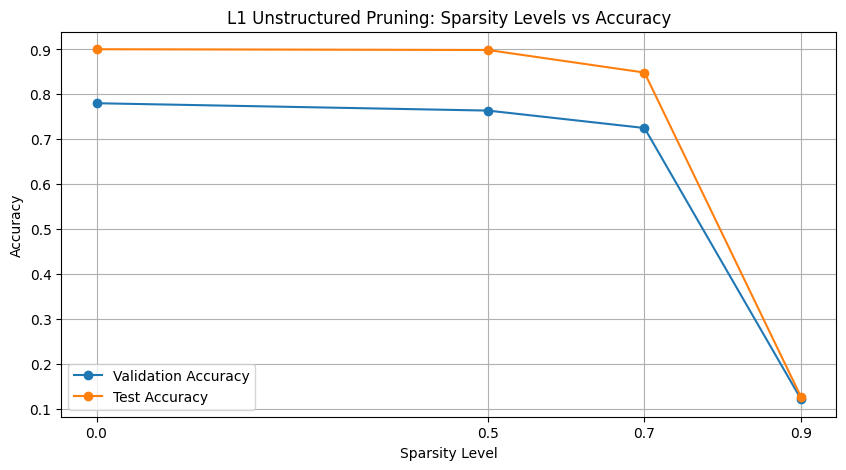

In [6]:
# Plot the sparsity levels vs accuracy for validation and test sets (baseline is considered as 0 sparsity)
sparsity_levels = [0.] + list(unstruct_pruned_amount_metrics_map.keys())
val_accuracies = [mobilenetv2_cifar10_val_accuracy_baseline] + [unstruct_pruned_amount_metrics_map[sparsity]["val_metrics"]["accuracy"] for sparsity in sparsity_levels[1:]]
test_accuracies = [mobilenetv2_cifar10_test_accuracy_baseline] + [unstruct_pruned_amount_metrics_map[sparsity]["test_metrics"]["accuracy"] for sparsity in sparsity_levels[1:]]
plt.figure(figsize=(10, 5))
plt.plot(sparsity_levels, val_accuracies, marker='o', label='Validation Accuracy')
plt.plot(sparsity_levels, test_accuracies, marker='o', label='Test Accuracy')
plt.title('L1 Unstructured Pruning: Sparsity Levels vs Accuracy')
plt.xlabel('Sparsity Level')
plt.ylabel('Accuracy')
plt.xticks(sparsity_levels)
plt.grid()
plt.legend()
plt.show()

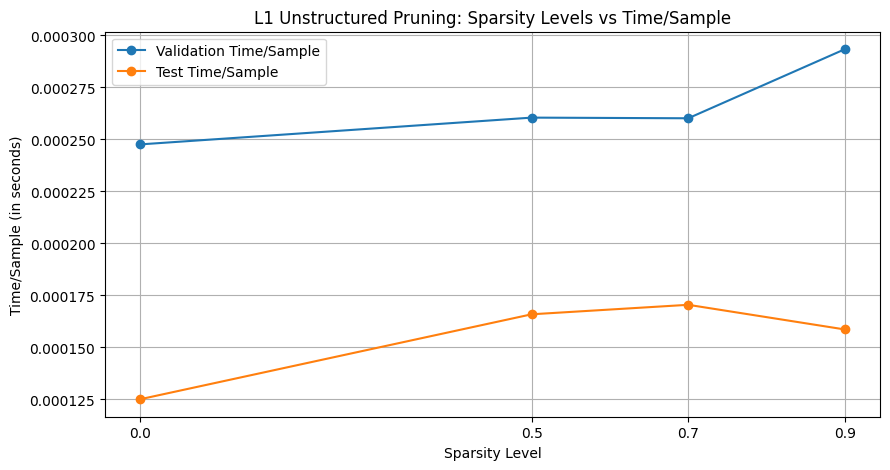

In [7]:
# Plot the average time per sample for validation and test sets (baseline is considered as 0 sparsity)
sparsity_levels = [0.] + list(unstruct_pruned_amount_metrics_map.keys())
val_time_per_sample = [mobilenetv2_cifar10_baseline_metadata["metrics_values"]["val_metrics"]["avg_time_per_sample"]] + [unstruct_pruned_amount_metrics_map[sparsity]["val_metrics"]["avg_time_per_sample"] for sparsity in sparsity_levels[1:]]
test_time_per_sample = [mobilenetv2_cifar10_baseline_metadata["metrics_values"]["test_metrics"]["avg_time_per_sample"]] + [unstruct_pruned_amount_metrics_map[sparsity]["test_metrics"]["avg_time_per_sample"] for sparsity in sparsity_levels[1:]]
plt.figure(figsize=(10, 5))
plt.plot(sparsity_levels, val_time_per_sample, marker='o', label='Validation Time/Sample')
plt.plot(sparsity_levels, test_time_per_sample, marker='o', label='Test Time/Sample')
plt.title('L1 Unstructured Pruning: Sparsity Levels vs Time/Sample')
plt.xlabel('Sparsity Level')
plt.ylabel('Time/Sample (in seconds)')
plt.xticks(sparsity_levels)
plt.grid()
plt.legend()
plt.show()

# L1 structured pruning

In [8]:
# Prune using L1 structured pruning, finetune, and evaluate for 0.5, 0.7, and 0.9 sparsity levels
struct_pruned_amount_model_version_map: dict[float, str] = {}
struct_pruned_amount_metrics_map: dict[float, dict[str, float]] = {}
for sparsity in [0.1, 0.3, 0.5]:
    print("***" * 20)
    # Prune and finetune the model
    _mobilnet_v2_cifar10_model, _ = get_mobilenetv2_cifar10_model(version="mobilenetv2_cifar10/baseline")
    mobilenetv2_cifar10_pruned = prune_finetune(
    model=_mobilnet_v2_cifar10_model.to(DEVICE),
    train_dataset=cifar10_train_dataset,
    val_dataset=cifar10_val_dataset,
    pruning_method="l1_structured_pruning",
    pruning_amount=sparsity,
    pruning_kwargs={
        "example_inputs": torch.randn(1, 3, 224, 224, device=DEVICE),  # Example input for structured pruning
    },
    batch_size=64,  # Adjust batch size as needed
    num_epochs=3,
    device=DEVICE,
    use_amp=True,
    dtype=DTYPE
)
    # Save the model and its metadata
    struct_pruned_amount_model_version_map[sparsity] = f"mobilenetv2_cifar10/l1_structured_pruning_{sparsity}"
    struct_pruned_amount_metrics_map[sparsity] = {
        "val_metrics": eval_model(
            model=mobilenetv2_cifar10_pruned,
            test_dataset=cifar10_val_dataset,
            batch_size=64,  # Adjust batch size as needed
            device=DEVICE,
            use_amp=False,
            dtype=torch.float32
        ),
        "test_metrics": eval_model(
            model=mobilenetv2_cifar10_pruned,
            test_dataset=cifar10_test_dataset,
            batch_size=64,  # Adjust batch size as needed
            device=DEVICE,
            use_amp=False,
            dtype=torch.float32
        ),
        "relative_sparsity": count_model_parameters(mobilenetv2_cifar10_pruned)/count_model_parameters(_mobilnet_v2_cifar10_model)
    }
    
    save_mobilenetv2_cifar10_model(
        model=mobilenetv2_cifar10_pruned,
        version=f"mobilenetv2_cifar10/l1_structured_pruning_{sparsity}",
        metrics_values=struct_pruned_amount_metrics_map[sparsity]
    )

2025-06-10 22:04:48,379 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loading MobileNetV2 model for CIFAR-10 from version: mobilenetv2_cifar10/baseline at /home/pbeuran/repos/nnopt/models


************************************************************


2025-06-10 22:04:48,462 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loaded metadata: {'metrics_values': {'val_metrics': {'accuracy': 0.7796, 'avg_loss': 0.6432003515243531, 'samples_per_second': 4038.3580272218437, 'avg_time_per_batch': 0.015672493328692545, 'avg_time_per_sample': 0.00024762539459334223, 'n_params': 2236682, 'n_nonzero_params': 2236682}, 'test_metrics': {'accuracy': 0.9016, 'avg_loss': 0.28529461288452146, 'samples_per_second': 7993.7841294417485, 'avg_time_per_batch': 0.00796797442669642, 'avg_time_per_sample': 0.0001250971984991338, 'n_params': 2236682, 'n_nonzero_params': 2236682}}}
2025-06-10 22:04:48,476 - nnopt.model.prune - INFO - Starting pruning with method: l1_structured_pruning, amount: 0.10
2025-06-10 22:04:48,477 - nnopt.model.prune - INFO - Applying L1 structured pruning with amount: 0.10
2025-06-10 22:04:48,478 - nnopt.model.prune - INFO - Initial model parameters: 2236682
2025-06-10 22:04:48,709 - nnopt.model.prune - INFO - Applied structured pruning t

Evaluation Complete: Avg Loss: 3.5239, Accuracy: 0.0856
Throughput: 4874.13 samples/sec | Avg Batch Time: 12.99 ms | Avg Sample Time: 0.21 ms
System Stats: CPU Usage: 11.50% | RAM Usage: 10.5/30.9GB (40.3%) | GPU 0 Util: 22.00% | GPU 0 Mem: 9.7/24.0GB (40.3%)


Epoch 1/3 [Validation]: 100%|██████████| 79/79 [00:04<00:00, 18.45it/s, acc=0.6324, cpu=3.3%, gpu_mem=9.7/24.0GB (40.4%), gpu_util=26.0%, loss=1.8115, ram=10.8/30.9GB (41.3%), samples/s=1158.9]  


Epoch 1/3, Train Loss: 1.1286, Train Acc: 0.6047, Train Throughput: 2140.70 samples/s | Val Loss: 1.0690, Val Acc: 0.6324, Val Throughput: 7138.34 samples/s | CPU Usage: 11.30% | RAM Usage: 10.5/30.9GB (40.4%) | GPU 0 Util: 16.00% | GPU 0 Mem: 9.7/24.0GB (40.4%)


Epoch 2/3 [Validation]: 100%|██████████| 79/79 [00:04<00:00, 18.39it/s, acc=0.6866, cpu=6.2%, gpu_mem=9.7/24.0GB (40.4%), gpu_util=37.0%, loss=1.3014, ram=10.7/30.9GB (41.1%), samples/s=1185.4]  


Epoch 2/3, Train Loss: 0.9097, Train Acc: 0.6840, Train Throughput: 2131.93 samples/s | Val Loss: 0.8868, Val Acc: 0.6866, Val Throughput: 7100.37 samples/s | CPU Usage: 10.40% | RAM Usage: 10.5/30.9GB (40.4%) | GPU 0 Util: 37.00% | GPU 0 Mem: 9.7/24.0GB (40.4%)


Epoch 3/3 [Validation]: 100%|██████████| 79/79 [00:04<00:00, 18.26it/s, acc=0.7200, cpu=3.1%, gpu_mem=9.7/24.0GB (40.4%), gpu_util=23.0%, loss=1.3661, ram=10.8/30.9GB (41.4%), samples/s=1156.7]  
2025-06-10 22:06:55,356 - nnopt.model.prune - INFO - Evaluating the pruned and finetuned model on the validation dataset...
2025-06-10 22:06:55,356 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.bfloat16, batch size: 64
2025-06-10 22:06:55,359 - nnopt.model.eval - INFO - Starting warmup for 5 batches...


Epoch 3/3, Train Loss: 0.8407, Train Acc: 0.7066, Train Throughput: 2126.82 samples/s | Val Loss: 0.8117, Val Acc: 0.7200, Val Throughput: 6974.88 samples/s | CPU Usage: 10.90% | RAM Usage: 10.5/30.9GB (40.5%) | GPU 0 Util: 19.00% | GPU 0 Mem: 9.7/24.0GB (40.4%)


[Warmup]: 100%|██████████| 5/5 [00:00<00:00,  7.35it/s]
2025-06-10 22:06:56,144 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 79/79 [00:04<00:00, 18.40it/s, acc=0.7180, cpu=0.0%, gpu_mem=9.7/24.0GB (40.4%), gpu_util=30.0%, loss=2.3497, ram=10.8/30.9GB (41.4%), samples/s=1081.1] 
2025-06-10 22:07:00,458 - nnopt.model.prune - INFO - Validation accuracy for pruned and finetuned model: 0.7180
2025-06-10 22:07:00,459 - nnopt.model.prune - INFO - Making pruning permanent by removing reparameterization...
2025-06-10 22:07:00,459 - nnopt.model.prune - WARNING - No pruning reparameterization was removed. Was the model pruned?
2025-06-10 22:07:00,460 - nnopt.model.prune - INFO - Removed pruning reparameterization from the pruned finetuned model.
2025-06-10 22:07:00,463 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.float32, batch size: 64
2025-06-10 22:07:00,466 - nnopt.model.eval - INFO - Starting warmup for 5 batches...


Evaluation Complete: Avg Loss: 0.8118, Accuracy: 0.7180
Throughput: 4780.04 samples/sec | Avg Batch Time: 13.24 ms | Avg Sample Time: 0.21 ms
System Stats: CPU Usage: 13.90% | RAM Usage: 10.5/30.9GB (40.5%) | GPU 0 Util: 30.00% | GPU 0 Mem: 9.7/24.0GB (40.4%)


[Warmup]: 100%|██████████| 5/5 [00:00<00:00,  7.14it/s]
2025-06-10 22:07:01,272 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 79/79 [00:04<00:00, 18.42it/s, acc=0.7096, cpu=3.3%, gpu_mem=9.7/24.0GB (40.4%), gpu_util=40.0%, loss=1.7654, ram=10.8/30.9GB (41.4%), samples/s=480.5]  
2025-06-10 22:07:05,580 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.float32, batch size: 64
2025-06-10 22:07:05,583 - nnopt.model.eval - INFO - Starting warmup for 5 batches...


Evaluation Complete: Avg Loss: 0.8295, Accuracy: 0.7096
Throughput: 3396.15 samples/sec | Avg Batch Time: 18.64 ms | Avg Sample Time: 0.29 ms
System Stats: CPU Usage: 12.70% | RAM Usage: 10.5/30.9GB (40.5%) | GPU 0 Util: 40.00% | GPU 0 Mem: 9.7/24.0GB (40.4%)


[Warmup]: 100%|██████████| 5/5 [00:00<00:00, 12.61it/s]
2025-06-10 22:07:06,077 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 157/157 [00:03<00:00, 41.86it/s, acc=0.8414, cpu=3.3%, gpu_mem=9.7/24.0GB (40.4%), gpu_util=40.0%, loss=0.2575, ram=10.7/30.9GB (41.2%), samples/s=968.6]  
2025-06-10 22:07:09,881 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Metadata saved to /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/l1_structured_pruning_0.1/metadata.json
2025-06-10 22:07:09,881 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Model saved to /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/l1_structured_pruning_0.1/model.pt
2025-06-10 22:07:09,882 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loading MobileNetV2 model for CIFAR-10 from version: mobilenetv2_cifar10/baseline at /home/pbeuran/repos/nnopt/models
2025-06-10 22:07:09,968 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loaded metadata: {'metrics_values': {'val_metrics': {'accuracy': 0.7796, 'avg_lo

Evaluation Complete: Avg Loss: 0.4565, Accuracy: 0.8414
Throughput: 6989.83 samples/sec | Avg Batch Time: 9.11 ms | Avg Sample Time: 0.14 ms
System Stats: CPU Usage: 11.50% | RAM Usage: 10.5/30.9GB (40.5%) | GPU 0 Util: 33.00% | GPU 0 Mem: 9.7/24.0GB (40.4%)
************************************************************


2025-06-10 22:07:10,075 - nnopt.model.prune - INFO - Applied structured pruning to 52 layers.
2025-06-10 22:07:10,076 - nnopt.model.prune - INFO - Final model parameters after structured pruning: 601161
2025-06-10 22:07:10,076 - nnopt.model.prune - INFO - Parameter reduction: 1635521 (73.12%)
2025-06-10 22:07:10,077 - nnopt.model.prune - INFO - Evaluating the pruned model on the validation dataset...
2025-06-10 22:07:10,078 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.bfloat16, batch size: 64
2025-06-10 22:07:10,080 - nnopt.model.eval - INFO - Starting warmup for 5 batches...
[Warmup]: 100%|██████████| 5/5 [00:00<00:00,  7.23it/s]
2025-06-10 22:07:10,871 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 79/79 [00:04<00:00, 18.37it/s, acc=0.0934, cpu=6.7%, gpu_mem=9.7/24.0GB (40.4%), gpu_util=21.0%, loss=3.2134, ram=10.8/30.9GB (41.3%), samples/s=383.5]  
2025-06-10 22:07:15,191 - nnopt.model.prune - INFO - Validation accuracy f

Evaluation Complete: Avg Loss: 5.3094, Accuracy: 0.0934
Throughput: 7201.37 samples/sec | Avg Batch Time: 8.79 ms | Avg Sample Time: 0.14 ms
System Stats: CPU Usage: 14.50% | RAM Usage: 10.5/30.9GB (40.5%) | GPU 0 Util: 21.00% | GPU 0 Mem: 9.7/24.0GB (40.4%)


Epoch 1/3 [Validation]: 100%|██████████| 79/79 [00:04<00:00, 18.28it/s, acc=0.5052, cpu=0.0%, gpu_mem=9.7/24.0GB (40.5%), gpu_util=22.0%, loss=2.1860, ram=10.7/30.9GB (41.2%), samples/s=1220.3]  


Epoch 1/3, Train Loss: 1.6263, Train Acc: 0.4127, Train Throughput: 2444.72 samples/s | Val Loss: 1.4117, Val Acc: 0.5052, Val Throughput: 8333.56 samples/s | CPU Usage: 10.40% | RAM Usage: 10.5/30.9GB (40.5%) | GPU 0 Util: 22.00% | GPU 0 Mem: 9.7/24.0GB (40.5%)


Epoch 2/3 [Validation]: 100%|██████████| 79/79 [00:04<00:00, 17.88it/s, acc=0.5568, cpu=3.4%, gpu_mem=9.7/24.0GB (40.5%), gpu_util=20.0%, loss=0.7826, ram=10.7/30.9GB (41.2%), samples/s=1202.8]  


Epoch 2/3, Train Loss: 1.2770, Train Acc: 0.5491, Train Throughput: 2482.29 samples/s | Val Loss: 1.2796, Val Acc: 0.5568, Val Throughput: 9146.42 samples/s | CPU Usage: 10.30% | RAM Usage: 10.5/30.9GB (40.5%) | GPU 0 Util: 12.00% | GPU 0 Mem: 9.7/24.0GB (40.5%)


Epoch 3/3 [Validation]: 100%|██████████| 79/79 [00:04<00:00, 18.57it/s, acc=0.5902, cpu=6.7%, gpu_mem=9.7/24.0GB (40.5%), gpu_util=20.0%, loss=1.4503, ram=10.6/30.9GB (40.8%), samples/s=1213.0]  
2025-06-10 22:09:17,449 - nnopt.model.prune - INFO - Evaluating the pruned and finetuned model on the validation dataset...
2025-06-10 22:09:17,450 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.bfloat16, batch size: 64
2025-06-10 22:09:17,453 - nnopt.model.eval - INFO - Starting warmup for 5 batches...


Epoch 3/3, Train Loss: 1.1271, Train Acc: 0.6008, Train Throughput: 2471.47 samples/s | Val Loss: 1.1522, Val Acc: 0.5902, Val Throughput: 9305.23 samples/s | CPU Usage: 11.10% | RAM Usage: 10.4/30.9GB (40.1%) | GPU 0 Util: 20.00% | GPU 0 Mem: 9.7/24.0GB (40.5%)


[Warmup]: 100%|██████████| 5/5 [00:00<00:00,  7.57it/s]
2025-06-10 22:09:18,220 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 79/79 [00:04<00:00, 18.12it/s, acc=0.5872, cpu=3.4%, gpu_mem=9.7/24.0GB (40.5%), gpu_util=22.0%, loss=1.1600, ram=10.7/30.9GB (40.9%), samples/s=1283.7]  
2025-06-10 22:09:22,599 - nnopt.model.prune - INFO - Validation accuracy for pruned and finetuned model: 0.5872
2025-06-10 22:09:22,600 - nnopt.model.prune - INFO - Making pruning permanent by removing reparameterization...
2025-06-10 22:09:22,600 - nnopt.model.prune - WARNING - No pruning reparameterization was removed. Was the model pruned?
2025-06-10 22:09:22,601 - nnopt.model.prune - INFO - Removed pruning reparameterization from the pruned finetuned model.
2025-06-10 22:09:22,601 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.float32, batch size: 64
2025-06-10 22:09:22,605 - nnopt.model.eval - INFO - Starting warmup for 5 batches...


Evaluation Complete: Avg Loss: 1.1554, Accuracy: 0.5872
Throughput: 6225.41 samples/sec | Avg Batch Time: 10.17 ms | Avg Sample Time: 0.16 ms
System Stats: CPU Usage: 10.80% | RAM Usage: 10.4/30.9GB (40.1%) | GPU 0 Util: 23.00% | GPU 0 Mem: 9.7/24.0GB (40.5%)


[Warmup]: 100%|██████████| 5/5 [00:00<00:00,  7.10it/s]
2025-06-10 22:09:23,414 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 79/79 [00:04<00:00, 18.23it/s, acc=0.6102, cpu=6.5%, gpu_mem=9.7/24.0GB (40.5%), gpu_util=26.0%, loss=1.1437, ram=10.6/30.9GB (40.9%), samples/s=484.8]  
2025-06-10 22:09:27,767 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.float32, batch size: 64
2025-06-10 22:09:27,770 - nnopt.model.eval - INFO - Starting warmup for 5 batches...


Evaluation Complete: Avg Loss: 1.1172, Accuracy: 0.6102
Throughput: 5493.83 samples/sec | Avg Batch Time: 11.52 ms | Avg Sample Time: 0.18 ms
System Stats: CPU Usage: 14.30% | RAM Usage: 10.4/30.9GB (40.1%) | GPU 0 Util: 26.00% | GPU 0 Mem: 9.7/24.0GB (40.5%)


[Warmup]: 100%|██████████| 5/5 [00:00<00:00, 13.42it/s]
2025-06-10 22:09:28,243 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 157/157 [00:03<00:00, 41.10it/s, acc=0.7128, cpu=3.3%, gpu_mem=9.7/24.0GB (40.5%), gpu_util=40.0%, loss=0.8188, ram=10.6/30.9GB (40.7%), samples/s=1008.0]  
2025-06-10 22:09:32,114 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Metadata saved to /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/l1_structured_pruning_0.3/metadata.json
2025-06-10 22:09:32,115 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Model saved to /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/l1_structured_pruning_0.3/model.pt
2025-06-10 22:09:32,115 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loading MobileNetV2 model for CIFAR-10 from version: mobilenetv2_cifar10/baseline at /home/pbeuran/repos/nnopt/models
2025-06-10 22:09:32,203 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loaded metadata: {'metrics_values': {'val_metrics': {'accuracy': 0.7796, 'avg_l

Evaluation Complete: Avg Loss: 0.8152, Accuracy: 0.7128
Throughput: 8524.95 samples/sec | Avg Batch Time: 7.47 ms | Avg Sample Time: 0.12 ms
System Stats: CPU Usage: 12.00% | RAM Usage: 10.4/30.9GB (40.1%) | GPU 0 Util: 35.00% | GPU 0 Mem: 9.7/24.0GB (40.5%)
************************************************************


2025-06-10 22:09:32,312 - nnopt.model.prune - INFO - Applied structured pruning to 52 layers.
2025-06-10 22:09:32,314 - nnopt.model.prune - INFO - Final model parameters after structured pruning: 214210
2025-06-10 22:09:32,314 - nnopt.model.prune - INFO - Parameter reduction: 2022472 (90.42%)
2025-06-10 22:09:32,315 - nnopt.model.prune - INFO - Evaluating the pruned model on the validation dataset...
2025-06-10 22:09:32,315 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.bfloat16, batch size: 64
2025-06-10 22:09:32,317 - nnopt.model.eval - INFO - Starting warmup for 5 batches...
[Warmup]: 100%|██████████| 5/5 [00:00<00:00,  6.71it/s]
2025-06-10 22:09:33,159 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 79/79 [00:04<00:00, 18.27it/s, acc=0.0922, cpu=5.2%, gpu_mem=9.7/24.0GB (40.5%), gpu_util=35.0%, loss=2.5625, ram=10.7/30.9GB (40.9%), samples/s=398.8]   
2025-06-10 22:09:37,502 - nnopt.model.prune - INFO - Validation accuracy 

Evaluation Complete: Avg Loss: 3.1682, Accuracy: 0.0922
Throughput: 9257.01 samples/sec | Avg Batch Time: 6.84 ms | Avg Sample Time: 0.11 ms
System Stats: CPU Usage: 11.60% | RAM Usage: 10.4/30.9GB (40.1%) | GPU 0 Util: 18.00% | GPU 0 Mem: 9.7/24.0GB (40.5%)


Epoch 1/3 [Validation]: 100%|██████████| 79/79 [00:04<00:00, 18.60it/s, acc=0.4052, cpu=3.6%, gpu_mem=9.7/24.0GB (40.6%), gpu_util=33.0%, loss=1.6887, ram=10.7/30.9GB (41.0%), samples/s=1305.4]  


Epoch 1/3, Train Loss: 1.8644, Train Acc: 0.3153, Train Throughput: 2508.51 samples/s | Val Loss: 1.6445, Val Acc: 0.4052, Val Throughput: 8969.89 samples/s | CPU Usage: 11.80% | RAM Usage: 10.4/30.9GB (40.2%) | GPU 0 Util: 33.00% | GPU 0 Mem: 9.7/24.0GB (40.6%)


Epoch 2/3 [Validation]: 100%|██████████| 79/79 [00:04<00:00, 18.09it/s, acc=0.4672, cpu=3.2%, gpu_mem=9.7/24.0GB (40.6%), gpu_util=27.0%, loss=1.2626, ram=10.7/30.9GB (41.0%), samples/s=1259.6]  


Epoch 2/3, Train Loss: 1.5615, Train Acc: 0.4351, Train Throughput: 2548.89 samples/s | Val Loss: 1.4714, Val Acc: 0.4672, Val Throughput: 8999.19 samples/s | CPU Usage: 11.10% | RAM Usage: 10.4/30.9GB (40.1%) | GPU 0 Util: 27.00% | GPU 0 Mem: 9.7/24.0GB (40.6%)


Epoch 3/3 [Validation]: 100%|██████████| 79/79 [00:04<00:00, 18.58it/s, acc=0.5120, cpu=3.2%, gpu_mem=9.7/24.0GB (40.6%), gpu_util=38.0%, loss=1.5254, ram=10.6/30.9GB (40.8%), samples/s=1355.3]  
2025-06-10 22:11:40,070 - nnopt.model.prune - INFO - Evaluating the pruned and finetuned model on the validation dataset...
2025-06-10 22:11:40,071 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.bfloat16, batch size: 64
2025-06-10 22:11:40,074 - nnopt.model.eval - INFO - Starting warmup for 5 batches...


Epoch 3/3, Train Loss: 1.4216, Train Acc: 0.4920, Train Throughput: 2517.47 samples/s | Val Loss: 1.3504, Val Acc: 0.5120, Val Throughput: 8703.53 samples/s | CPU Usage: 12.30% | RAM Usage: 10.4/30.9GB (40.2%) | GPU 0 Util: 38.00% | GPU 0 Mem: 9.7/24.0GB (40.6%)


[Warmup]: 100%|██████████| 5/5 [00:00<00:00,  6.69it/s]
2025-06-10 22:11:40,919 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 79/79 [00:04<00:00, 18.49it/s, acc=0.5212, cpu=0.0%, gpu_mem=9.7/24.0GB (40.6%), gpu_util=28.0%, loss=1.4256, ram=10.7/30.9GB (41.1%), samples/s=1324.3] 
2025-06-10 22:11:45,210 - nnopt.model.prune - INFO - Validation accuracy for pruned and finetuned model: 0.5212
2025-06-10 22:11:45,211 - nnopt.model.prune - INFO - Making pruning permanent by removing reparameterization...
2025-06-10 22:11:45,211 - nnopt.model.prune - WARNING - No pruning reparameterization was removed. Was the model pruned?
2025-06-10 22:11:45,212 - nnopt.model.prune - INFO - Removed pruning reparameterization from the pruned finetuned model.
2025-06-10 22:11:45,212 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.float32, batch size: 64
2025-06-10 22:11:45,216 - nnopt.model.eval - INFO - Starting warmup for 5 batches...


Evaluation Complete: Avg Loss: 1.3431, Accuracy: 0.5212
Throughput: 7704.52 samples/sec | Avg Batch Time: 8.21 ms | Avg Sample Time: 0.13 ms
System Stats: CPU Usage: 11.40% | RAM Usage: 10.4/30.9GB (40.1%) | GPU 0 Util: 28.00% | GPU 0 Mem: 9.7/24.0GB (40.6%)


[Warmup]: 100%|██████████| 5/5 [00:00<00:00,  7.36it/s]
2025-06-10 22:11:45,995 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 79/79 [00:04<00:00, 18.60it/s, acc=0.5186, cpu=3.4%, gpu_mem=9.7/24.0GB (40.6%), gpu_util=18.0%, loss=1.5806, ram=10.7/30.9GB (40.9%), samples/s=490.5]   
2025-06-10 22:11:50,261 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.float32, batch size: 64
2025-06-10 22:11:50,264 - nnopt.model.eval - INFO - Starting warmup for 5 batches...


Evaluation Complete: Avg Loss: 1.3277, Accuracy: 0.5186
Throughput: 11781.24 samples/sec | Avg Batch Time: 5.37 ms | Avg Sample Time: 0.08 ms
System Stats: CPU Usage: 11.30% | RAM Usage: 10.4/30.9GB (40.1%) | GPU 0 Util: 18.00% | GPU 0 Mem: 9.7/24.0GB (40.6%)


[Warmup]: 100%|██████████| 5/5 [00:00<00:00, 12.60it/s]
2025-06-10 22:11:50,768 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 157/157 [00:03<00:00, 41.43it/s, acc=0.6154, cpu=3.2%, gpu_mem=9.7/24.0GB (40.6%), gpu_util=34.0%, loss=0.9372, ram=10.7/30.9GB (41.0%), samples/s=973.0]   
2025-06-10 22:11:54,605 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Metadata saved to /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/l1_structured_pruning_0.5/metadata.json
2025-06-10 22:11:54,606 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Model saved to /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/l1_structured_pruning_0.5/model.pt


Evaluation Complete: Avg Loss: 1.0626, Accuracy: 0.6154
Throughput: 10291.63 samples/sec | Avg Batch Time: 6.19 ms | Avg Sample Time: 0.10 ms
System Stats: CPU Usage: 12.70% | RAM Usage: 10.4/30.9GB (40.2%) | GPU 0 Util: 29.00% | GPU 0 Mem: 9.7/24.0GB (40.6%)


In [9]:
# Print the sparsity and accuracy results
for sparsity, metrics in struct_pruned_amount_metrics_map.items():
    print(f"Sparsity: {sparsity:.2f}, Relative Sparsity: {metrics['relative_sparsity']:.2f}, Validation Accuracy: {metrics['val_metrics']['accuracy']:.2f}, Test Accuracy: {metrics['test_metrics']['accuracy']:.2f}")

Sparsity: 0.10, Relative Sparsity: 1.00, Validation Accuracy: 0.71, Test Accuracy: 0.84
Sparsity: 0.30, Relative Sparsity: 1.00, Validation Accuracy: 0.61, Test Accuracy: 0.71
Sparsity: 0.50, Relative Sparsity: 1.00, Validation Accuracy: 0.52, Test Accuracy: 0.62


In [10]:
# Print the average time per sample for validation and test sets (baseline is considered as 0 sparsity)
for sparsity, metrics in struct_pruned_amount_metrics_map.items():
    print(f"Sparsity: {sparsity:.2f}, Validation Time/Sample: {metrics['val_metrics']['avg_time_per_sample']:.4f}, Test Time/Sample: {metrics['test_metrics']['avg_time_per_sample']:.8f}")

Sparsity: 0.10, Validation Time/Sample: 0.0003, Test Time/Sample: 0.00014307
Sparsity: 0.30, Validation Time/Sample: 0.0002, Test Time/Sample: 0.00011730
Sparsity: 0.50, Validation Time/Sample: 0.0001, Test Time/Sample: 0.00009717


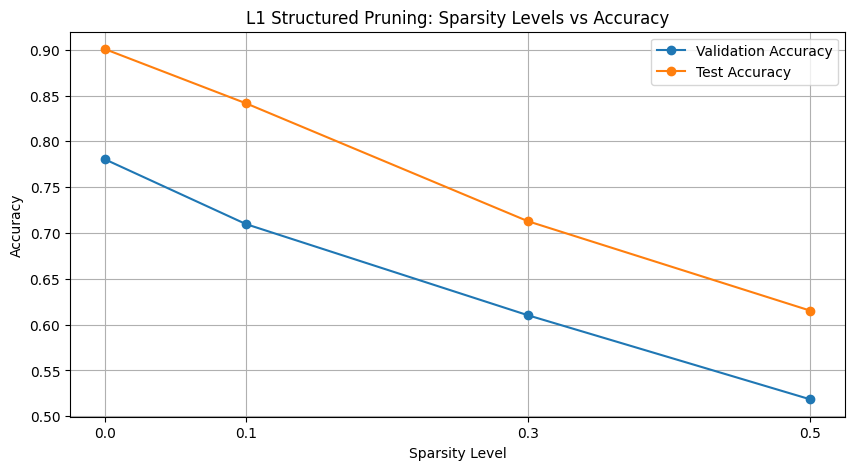

In [11]:
# Plot the sparsity levels vs accuracy for validation and test sets (baseline is considered as 0 sparsity)
sparsity_levels = [0.] + list(struct_pruned_amount_metrics_map.keys())
val_accuracies = [mobilenetv2_cifar10_val_accuracy_baseline] + [struct_pruned_amount_metrics_map[sparsity]["val_metrics"]["accuracy"] for sparsity in sparsity_levels[1:]]
test_accuracies = [mobilenetv2_cifar10_test_accuracy_baseline] + [struct_pruned_amount_metrics_map[sparsity]["test_metrics"]["accuracy"] for sparsity in sparsity_levels[1:]]
plt.figure(figsize=(10, 5))
plt.plot(sparsity_levels, val_accuracies, marker='o', label='Validation Accuracy')
plt.plot(sparsity_levels, test_accuracies, marker='o', label='Test Accuracy')
plt.title('L1 Structured Pruning: Sparsity Levels vs Accuracy')
plt.xlabel('Sparsity Level')
plt.ylabel('Accuracy')
plt.xticks(sparsity_levels)
plt.grid()
plt.legend()
plt.show()

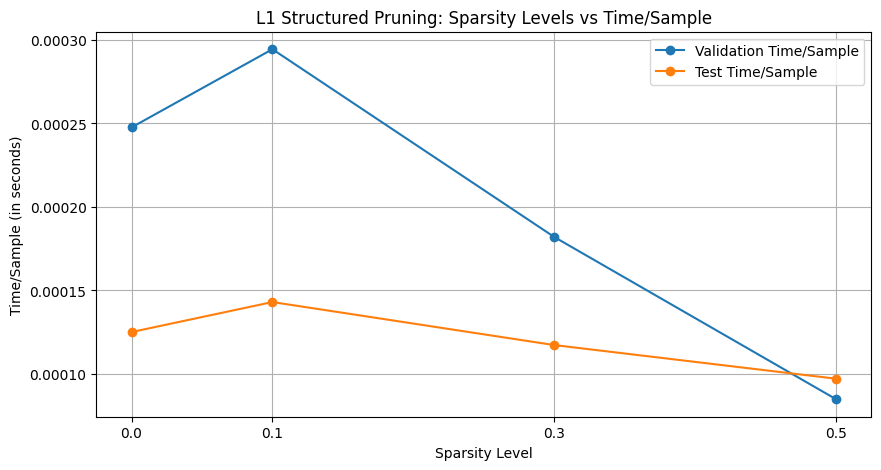

In [12]:
# Plot the average time per sample for validation and test sets (baseline is considered as 0 sparsity)
sparsity_levels = [0.] + list(struct_pruned_amount_metrics_map.keys())
val_time_per_sample = [mobilenetv2_cifar10_baseline_metadata["metrics_values"]["val_metrics"]["avg_time_per_sample"]] + [struct_pruned_amount_metrics_map[sparsity]["val_metrics"]["avg_time_per_sample"] for sparsity in sparsity_levels[1:]]
test_time_per_sample = [mobilenetv2_cifar10_baseline_metadata["metrics_values"]["test_metrics"]["avg_time_per_sample"]] + [struct_pruned_amount_metrics_map[sparsity]["test_metrics"]["avg_time_per_sample"] for sparsity in sparsity_levels[1:]]
plt.figure(figsize=(10, 5))
plt.plot(sparsity_levels, val_time_per_sample, marker='o', label='Validation Time/Sample')
plt.plot(sparsity_levels, test_time_per_sample, marker='o', label='Test Time/Sample')
plt.title('L1 Structured Pruning: Sparsity Levels vs Time/Sample')
plt.xlabel('Sparsity Level')
plt.ylabel('Time/Sample (in seconds)')
plt.xticks(sparsity_levels)
plt.grid()
plt.legend()
plt.show()